## 数据载入&样本构造

In [1]:
from feat import *
from utils import *

In [2]:
# 原始数据路径&缓存数据路径
ori_data_path = "../data/"
cache_path = "../cache/"

In [3]:
start = "2016-01-31 23:59:02" # 行为记录起始时间戳
end = "2016-04-15 23:59:59" # 行为记录结束时间戳

In [4]:
test_end_date = "2016-04-08 23:59:59" 
train_end_date = "2016-04-01 23:59:59"
label_span = 7
sample_span = 7
action_feat_span = 30 

In [5]:
action = get_action()

In [6]:
# 训练集划窗行为数据切分
train_win_set = [(train_end_date, action_feat_span),
                 (train_end_date, sample_span),
                 (test_end_date, label_span)]
train_feat_action, train_sample_action, train_label_action = get_slide_win_action(action, "datetime", train_win_set)

In [9]:
# 测试集划窗行为切分
test_win_set = [(test_end_date, action_feat_span),
                (test_end_date, sample_span),
                (end, label_span)]
test_feat_action, test_sample_action, test_label_action = get_slide_win_action(action, "datetime", test_win_set)

In [39]:
# 训练样本
train_sample = get_sample(train_sample_action)
train_label = get_label(train_label_action)
train_set = pd.merge(train_sample, train_label, on=["user_id","sku_id"], how="left")
train_set["label"].fillna(0,inplace=True)

In [40]:
from collections import Counter
print("用户数量：")
print(train_set["user_id"].nunique())
print("商品数量：")
print(train_set["sku_id"].nunique())
print("正负样本：")
print(Counter(train_set["label"]))

用户数量：
40737
商品数量：
2744
正负样本：
Counter({0.0: 181167, 1.0: 423})


In [41]:
# 测试样本
test_sample = get_sample(test_sample_action)
test_label = get_label(test_label_action)
test_set = pd.merge(test_sample, test_label, on=["user_id","sku_id"], how="left")
test_set["label"].fillna(0,inplace=True)

In [42]:
print("用户数量：")
print(test_set["user_id"].nunique())
print("商品数量：")
print(test_set["sku_id"].nunique())
print("正负样本：")
print(Counter(test_set["label"]))

用户数量：
44336
商品数量：
2779
正负样本：
Counter({0.0: 220476, 1.0: 579})


## 特征构造

### 用户基本特征和产品基本特征

In [12]:
user_base_feat = get_user_base_feat()

In [13]:
product_base_feat = get_product_base_feat()

In [14]:
train_set = pd.merge(train_set,user_base_feat,on=["user_id"],how="left")
train_set = pd.merge(train_set,product_base_feat,on=["sku_id"],how="left")

In [15]:
test_set = pd.merge(test_set,user_base_feat,on=["user_id"],how="left")
test_set = pd.merge(test_set,product_base_feat,on=["sku_id"],how="left")

In [16]:
train_X = train_set.drop(columns=["user_id","sku_id","label","cate","brand"],axis=1)
train_y = train_set.loc[:,["label"]]
test_X = test_set.drop(columns=["user_id","sku_id","label","cate","brand"],axis=1)
test_y = test_set.loc[:,["label"]]

In [17]:
train_X.columns

Index(['sex', 'user_lv_cd', 'age_rank', 'reg_age', 'a1', 'a2', 'a3',
       'comment_num', 'has_bad_comment', 'bad_comment_rate'],
      dtype='object')

In [18]:
# 试一下
model = lgb.LGBMClassifier()
model.fit(train_X,train_y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
# auc
from sklearn.metrics import roc_auc_score
print("训练集auc")
print(roc_auc_score(train_y,model.predict_proba(train_X)[:,1]))
print("测试集auc")
print(roc_auc_score(test_y,model.predict_proba(test_X)[:,1]))

训练集auc
0.9609248192271989
测试集auc
0.20430443957905325


仅依赖用户侧和商品侧的基本特征，模型泛化能力较差

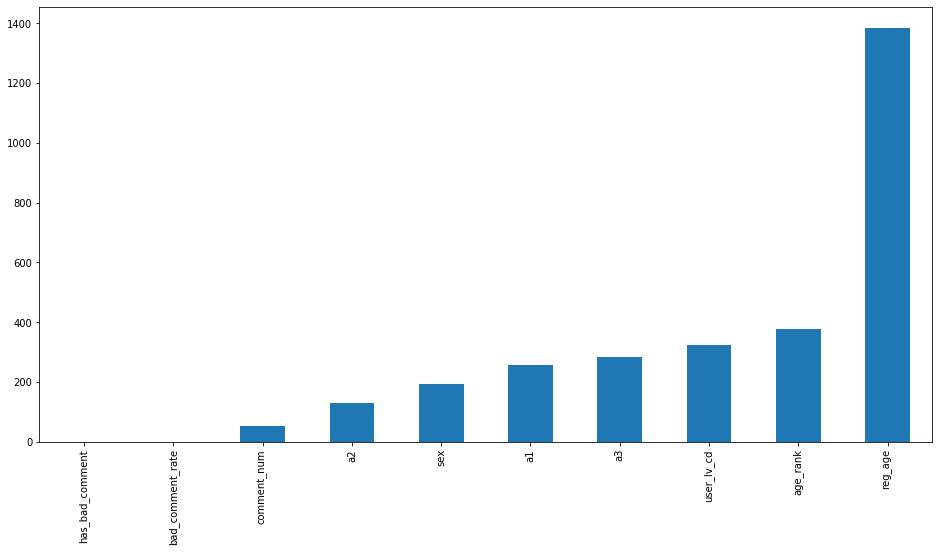

In [20]:
# 特征重要度
feature_importances = model.feature_importances_
feature_importances = pd.Series(feature_importances,index=train_X.columns)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
feature_importances.sort_values().plot(kind="bar")

### 用户行为特征

In [43]:
act_train = action.loc[action.datetime<train_end_date,:]
act_test = action.loc[action.datetime<test_end_date,:]
train_user_act_feat = get_user_acc_action_feat(act_train,train_end_date,cache_path)
test_user_act_feat = get_user_acc_action_feat(act_test,test_end_date,cache_path)

In [44]:
train_set = pd.merge(train_set,train_user_act_feat,on=["user_id"],how="left")
test_set = pd.merge(test_set,test_user_act_feat,on=["user_id"],how="left")

In [46]:
train_X = train_set.drop(columns=["user_id","sku_id","label"],axis=1)
train_y = train_set.loc[:,["label"]]
test_X = test_set.drop(columns=["user_id","sku_id","label"],axis=1)
test_y = test_set.loc[:,["label"]]

In [47]:
model = lgb.LGBMClassifier()
model.fit(train_X,train_y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
# auc
from sklearn.metrics import roc_auc_score
print("训练集auc")
print(roc_auc_score(train_y,model.predict_proba(train_X)[:,1]))
print("测试集auc")
print(roc_auc_score(test_y,model.predict_proba(test_X)[:,1]))

训练集auc
0.9900522147968932
测试集auc
0.7703704962298404


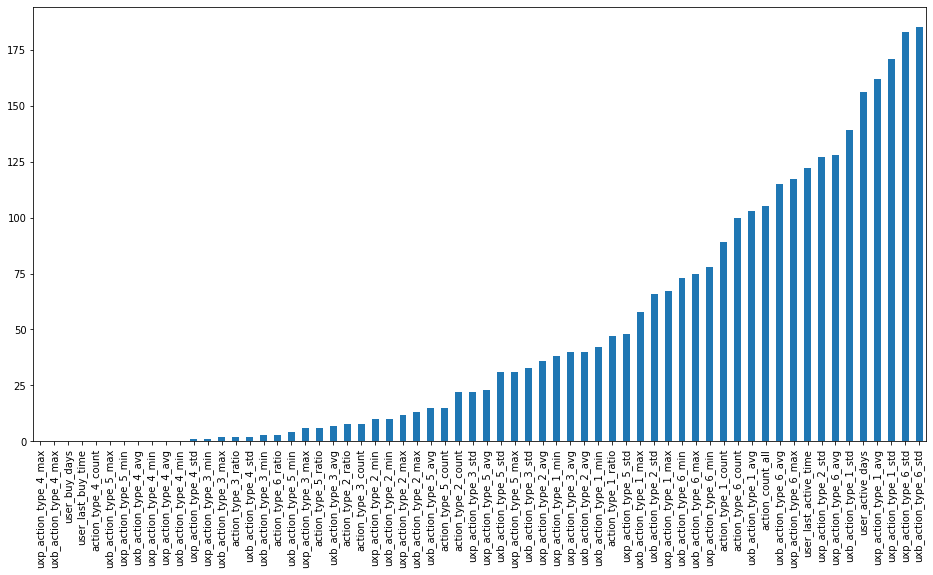

In [49]:
# 特征重要度
feature_importances = model.feature_importances_
feature_importances = pd.Series(feature_importances,index=train_X.columns)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
feature_importances.sort_values().plot(kind="bar")

### 用户x产品交互特征

In [50]:
train_uxp_act_feat = get_uxp_action_acc_feat(act_train, train_end_date, cache_path)
test_uxp_act_feat = get_uxp_action_acc_feat(act_test, test_end_date, cache_path)

In [51]:
train_set = pd.merge(train_set,train_uxp_act_feat,on=["user_id","sku_id"],how="left")
test_set = pd.merge(test_set,test_uxp_act_feat,on=["user_id","sku_id"],how="left")

In [52]:
train_X = train_set.drop(columns=["user_id","sku_id","label"],axis=1)
train_y = train_set.loc[:,["label"]]
test_X = test_set.drop(columns=["user_id","sku_id","label"],axis=1)
test_y = test_set.loc[:,["label"]]

In [53]:
model = lgb.LGBMClassifier()
model.fit(train_X,train_y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
# auc
from sklearn.metrics import roc_auc_score
print("训练集auc")
print(roc_auc_score(train_y,model.predict_proba(train_X)[:,1]))
print("测试集auc")
print(roc_auc_score(test_y,model.predict_proba(test_X)[:,1]))

训练集auc
0.9665389707896039
测试集auc
0.821791196099781


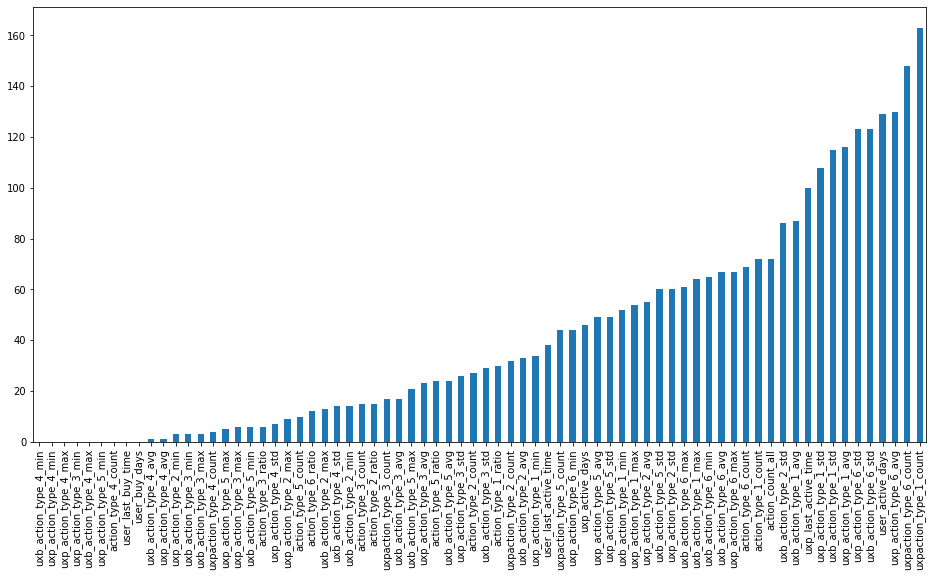

In [55]:
# 特征重要度
feature_importances = model.feature_importances_
feature_importances = pd.Series(feature_importances,index=train_X.columns)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
feature_importances.sort_values().plot(kind="bar")

### 产品侧行为特征

In [56]:
train_p_act_feat = get_product_action_acc_feat(act_train, train_end_date, cache_path)
test_p_act_feat = get_product_action_acc_feat(act_test, test_end_date, cache_path)

In [57]:
train_set = pd.merge(train_set, train_p_act_feat, on=["sku_id"], how="left")
test_set = pd.merge(test_set, test_p_act_feat, on=["sku_id"], how="left")

In [59]:
train_X = train_set.drop(columns=["sku_id","user_id","label"], axis=1)
test_X = test_set.drop(columns=["sku_id","user_id","label"], axis=1)
train_Y = train_set["label"]
test_Y = test_set["label"]

In [60]:
model.fit(train_X,train_Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [61]:
# auc
from sklearn.metrics import roc_auc_score
print("训练集auc")
print(roc_auc_score(train_y,model.predict_proba(train_X)[:,1]))
print("测试集auc")
print(roc_auc_score(test_y,model.predict_proba(test_X)[:,1]))

训练集auc
0.9227464345586817
测试集auc
0.748688596546063


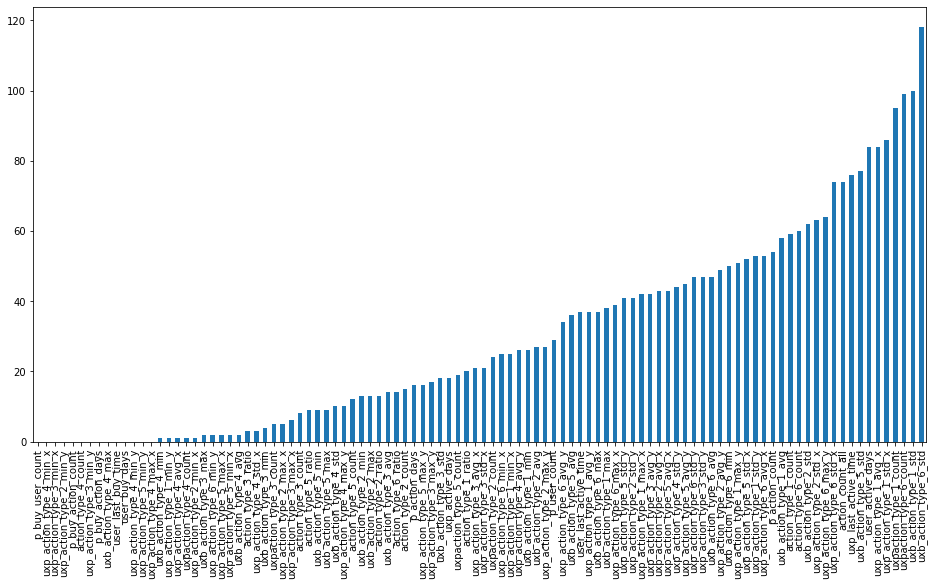

In [62]:
# 特征重要度
feature_importances = model.feature_importances_
feature_importances = pd.Series(feature_importances,index=train_X.columns)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
feature_importances.sort_values().plot(kind="bar")

## 调参

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### 迭代轮次试验

In [69]:
# 基本参数设定
params = {
    "boosting_type":"gbdt",
    "objective":"binary",
    "metric":"auc",
    "ntheard": 8,
    "learning_rate":0.1, # 较大学习率
    "num_leaves":30,
    "max_depth":5,
    "subsample":0.8,
    "colsample_bytree":0.8    
}
# 使用内置训练方法，得到最优迭代轮次
data_train = lgb.Dataset(train_X.values,train_Y.values)
cv_result = lgb.cv(params, data_train, num_boost_round=1000, early_stopping_rounds=200, nfold=5, stratified=True, metrics="auc", shuffle=True)

In [70]:
print("最优迭代轮次:"+str(len(cv_result["auc-mean"])))
print("最好auc得分:"+str(max(cv_result["auc-mean"])))

最优迭代轮次:59
最好auc得分:0.8400026028662755


### 调整最大树深和最大叶子节点树

In [74]:
# 调整最大树深和最大叶子节点树
grid_params1 = {
    "max_depth":range(3,8,1),
    "num_leaves":range(5,100,5)
}
skf = StratifiedKFold(n_splits=5, shuffle=True)
model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", metrics="auc", learning_rate=0.1, n_estimators=59, bagging_fraction=0.8, feature_fraction = 0.8)
gridSearch = GridSearchCV(estimator=model, param_grid=grid_params1, scoring="roc_auc", cv=skf, n_jobs=-1)
gridSearch.fit(train_X,train_Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      metrics='auc', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0,...timators=59,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
             

In [76]:
gridSearch.best_estimator_, gridSearch.best_params_, gridSearch.best_score_

(LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
                colsample_bytree=1.0, feature_fraction=0.8,
                importance_type='split', learning_rate=0.1, max_depth=5,
                metrics='auc', min_child_samples=20, min_child_weight=0.001,
                min_split_gain=0.0, n_estimators=59, n_jobs=-1, num_leaves=10,
                objective='binary', random_state=None, reg_alpha=0.0,
                reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'max_depth': 5, 'num_leaves': 10},
 0.8778309153867763)

### 调整min_data_in_leaf(叶子最小样本量)和max_bin

In [77]:
# 调整min_data_in_leaf(叶子最小样本量)和max_bin
grid_params1 = {
    "min_data_in_leaf":range(21,200,10),
    "max_bin":range(5,256,10)
}
model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", metrics="auc", learning_rate=0.1, n_estimators=59, bagging_fraction=0.8, feature_fraction = 0.8,\
                           max_depth=5, num_leaves=10)
gridSearch = GridSearchCV(estimator=model, param_grid=grid_params1, scoring="roc_auc", cv=skf, n_jobs=-1)
gridSearch.fit(train_X,train_Y)

D:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=5,
                                      metrics='auc', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n...,
                                      n_jobs=-1, num_leaves=10,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                       

In [78]:
gridSearch.best_estimator_, gridSearch.best_params_, gridSearch.best_score_

(LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
                colsample_bytree=1.0, feature_fraction=0.8,
                importance_type='split', learning_rate=0.1, max_bin=15,
                max_depth=5, metrics='auc', min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=161, min_split_gain=0.0,
                n_estimators=59, n_jobs=-1, num_leaves=10, objective='binary',
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 {'max_bin': 15, 'min_data_in_leaf': 161},
 0.900738134949461)

### feature_fraction(特征抽样比例),bagging_fraction(样本抽样比例),bagging_freq

In [83]:
# feature_fraction(特征抽样比例),bagging_fraction(样本抽样比例),bagging_freq
grid_params3 = {
    "feature_fraction":[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "bagging_fraction":[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "bagging_freq":range(0,60,10)
}
model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", metrics="auc", learning_rate=0.1, n_estimators=59, bagging_fraction=0.8, feature_fraction = 0.8,\
                           max_depth=5, num_leaves=10, max_bin=15, min_data_in_leaf=161)
gridSearch = GridSearchCV(estimator=model, param_grid=grid_params3, scoring="roc_auc", cv=skf, n_jobs=-1)
gridSearch.fit(train_X,train_Y)

D:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=15,
                                      max_depth=5, metrics='auc',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_...
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
      

In [84]:
gridSearch.best_estimator_, gridSearch.best_params_, gridSearch.best_score_

(LGBMClassifier(bagging_fraction=0.9, bagging_freq=20, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                importance_type='split', learning_rate=0.1, max_bin=15,
                max_depth=5, metrics='auc', min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=161, min_split_gain=0.0,
                n_estimators=59, n_jobs=-1, num_leaves=10, objective='binary',
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 {'bagging_fraction': 0.9, 'bagging_freq': 20, 'feature_fraction': 0.4},
 0.9006017118074119)

### L1和L2正则化系数

In [85]:
# L1和L2正则化系数
grid_params4 = {
    "lambda_l1":[1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    "lambda_l2":[1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
}
model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", metrics="auc", learning_rate=0.1, n_estimators=59, bagging_fraction=0.9, feature_fraction = 0.4,\
                           max_depth=5, num_leaves=10, max_bin=15, min_data_in_leaf=161, bagging_freq=20)
gridSearch = GridSearchCV(estimator=model, param_grid=grid_params4, scoring="roc_auc", cv=skf, n_jobs=-1)
gridSearch.fit(train_X,train_Y)

D:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=20,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.4,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=15,
                                      max_depth=5, metrics='auc',
                                      min_child_samples=20,
                                      min_child_weight...
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                        

In [86]:
gridSearch.best_estimator_, gridSearch.best_params_, gridSearch.best_score_

(LGBMClassifier(bagging_fraction=0.9, bagging_freq=20, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                importance_type='split', lambda_l1=0.3, lambda_l2=0.7,
                learning_rate=0.1, max_bin=15, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=161, min_split_gain=0.0, n_estimators=59,
                n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'lambda_l1': 0.3, 'lambda_l2': 0.7},
 0.906460599944546)

### min_split_gain最小分裂增益

In [88]:
# min_split_gain最小分裂增益
grid_params5 = {
    "min_split_gain":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", metrics="auc", learning_rate=0.1, n_estimators=59, bagging_fraction=0.9, feature_fraction = 0.4,\
                           max_depth=5, num_leaves=10, max_bin=15, min_data_in_leaf=161, bagging_freq=20, lambda_l1=0.3, lambda_l2=0.7)
gridSearch = GridSearchCV(estimator=model, param_grid=grid_params5, scoring="roc_auc", cv=skf, n_jobs=-1)
gridSearch.fit(train_X,train_Y)

D:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=20,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.4,
                                      importance_type='split', lambda_l1=0.3,
                                      lambda_l2=0.7, learning_rate=0.1,
                                      max_bin=15, max_depth=5, metrics='auc',
                                      min_child...
                                      n_estimators=59, n_jobs=-1, num_leaves=10,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsam

In [89]:
gridSearch.best_estimator_, gridSearch.best_params_, gridSearch.best_score_

(LGBMClassifier(bagging_fraction=0.9, bagging_freq=20, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                importance_type='split', lambda_l1=0.3, lambda_l2=0.7,
                learning_rate=0.1, max_bin=15, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=161, min_split_gain=0.9, n_estimators=59,
                n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'min_split_gain': 0.9},
 0.9031428338142693)

### 降低学习率，提高迭代轮次

In [92]:
# 降低学习率，提高迭代轮次
model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", metrics="auc", learning_rate=0.001, n_estimators=6000, bagging_fraction=0.9, feature_fraction = 0.4,\
                           max_depth=5, num_leaves=10, max_bin=15, min_data_in_leaf=161, bagging_freq=20, lambda_l1=0.3, lambda_l2=0.7)
model.fit(train_X, train_Y)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=20, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', lambda_l1=0.3, lambda_l2=0.7,
               learning_rate=0.001, max_bin=15, max_depth=5, metrics='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=161, min_split_gain=0.0, n_estimators=6000,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## 模型效果

### auc计算

In [94]:
# 计算auc，特征重要度，验证模型
res = model.predict_proba(test_X)
print("auc")
print(roc_auc_score(test_Y,res[:,1]))

auc
0.9051444110514727


### 特征重要度

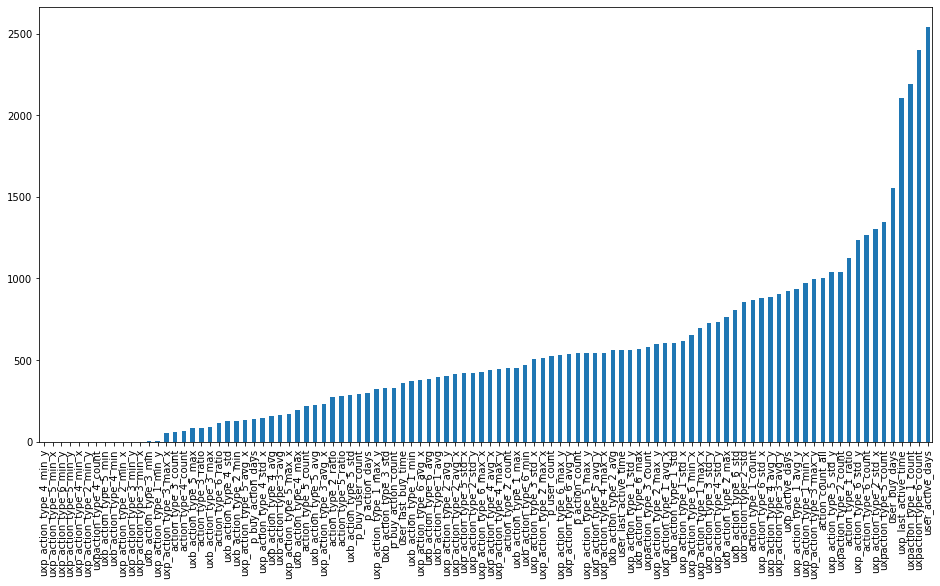

In [95]:
# 特征重要度
feature_importances = model.feature_importances_
feature_importances = pd.Series(feature_importances, index=train_X.columns)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
feature_importances.sort_values().plot(kind="bar")

### ROC曲线

In [96]:
# ROC_curve&可视化
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_Y, res[:,1])

In [100]:
roc_data = pd.DataFrame({"fpr":fpr,"tpr":tpr})

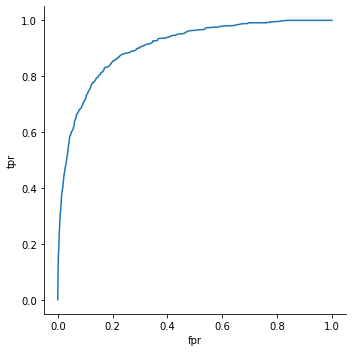

In [102]:
import seaborn as sns
sns.relplot(x="fpr", y="tpr", data=roc_data, kind="line", ci=None)